In [397]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [413]:
#loading the data
def load_data(path):
    return pd.read_csv(path)

# cleaning data
def cleaning_data(df):
    df = df[df['year']<2060]
    df['age'] = df.year.max() - df['year']
    df = df.drop('year', axis=1)
    return df

# model result
def model_evaluate(model, X_train, X_test, y_train, y_test):
    # Evaluate the training score
    best_model = model.best_estimator_
    y_train_pred = best_model.predict(X_train)
    training_score = r2_score(y_train, y_train_pred)
    print(f"Training R^2 score: {training_score}")

    # Evaluate the test score
    y_test_pred = best_model.predict(X_test)
    test_score = r2_score(y_test, y_test_pred)
    print(f"Test R^2 score: {test_score}")

    # Cross-validation scores
    mean_cv_score = model.best_score_
    print(f"Cross-validated R^2 score: {mean_cv_score}")
    
def feature_importance(model):
    # Get the best model
    best_model = model.best_estimator_
    # Access the fitted preprocessor step
    fitted_preprocessor = best_model.named_steps['preprocessor']

    # Get feature names for numerical and categorical features
    numerical_feature_names = fitted_preprocessor.named_transformers_['num'].named_steps['poly'].get_feature_names_out(numerical_features)
    categorical_feature_names = fitted_preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)

    # Combine feature names
    feature_names = np.concatenate([numerical_feature_names, categorical_feature_names])

    # Get coefficients
    coefficients = best_model.named_steps['regressor'].coef_
    return feature_names, coefficients


In [384]:
data = load_data(r"D:\A Portfolio Projects\ML Projects\Ford_uk_2nd_car\ford.csv")
data = cleaning_data(data)


In [385]:

X = data.drop('price', axis=1)
y = data['price']
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [386]:
# Define categorical and numerical features
categorical_features = X.select_dtypes(include=object).columns.tolist()
numerical_features = X.select_dtypes(exclude=object).columns.tolist()

In [387]:
# Pipeine & transfomer

skew_transfomer = ColumnTransformer(
    transformers=[
        ('sqrt', FunctionTransformer(), ['mileage', 'engineSize', 'age'])
    ],
    remainder='passthrough'
)

numerical_transformer = Pipeline(steps=[
    ('remove_skew', skew_transfomer),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False))
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



## Linear Regression

In [398]:
# Define the lasso model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'preprocessor__num__remove_skew__sqrt__func': [np.log1p, np.sqrt, np.square],
    'preprocessor__num__scaler': [StandardScaler()],
    'preprocessor__num__poly__degree': [2,3],
    'preprocessor__num__poly__include_bias': [False],
    'preprocessor__num__poly__interaction_only': [False],
}

# Apply GridSearchCV
linear = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='r2')
linear.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('remove_skew',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('sqrt',
                                                                                                                           FunctionTransformer(),
                                                                                                                           ['mileage',
                                                                                                                            'engineSize',
                                                                                                                            'age'])])),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['mileage',
                                                                          'tax',
                                                                          'mpg...
                                       ('regressor', LinearRegression())]),
             n_jobs=-1,
             param_grid={'preprocessor__num__poly__degree': [2, 3],
                         'preprocessor__num__poly__include_bias': [False],
                         'preprocessor__num__poly__interaction_only': [False],
                         'preprocessor__num__remove_skew__sqrt__func': [<ufunc 'log1p'>,
                                                                        <ufunc 'sqrt'>,
                                                                        <ufunc 'square'>],
                         'preprocessor__num__scaler': [StandardScaler()]},
             scoring='r2')

In [399]:
linear.best_params_

{'preprocessor__num__poly__degree': 3,
 'preprocessor__num__poly__include_bias': False,
 'preprocessor__num__poly__interaction_only': False,
 'preprocessor__num__remove_skew__sqrt__func': <ufunc 'sqrt'>,
 'preprocessor__num__scaler': StandardScaler()}

In [400]:
model_evaluate(linear, X_train, X_test, y_train, y_test)

Training R^2 score: 0.8955792022045609
Test R^2 score: 0.8949799257246059
Cross-validated R^2 score: 0.8882365195698136


## LASSO

In [388]:
# Define the lasso model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'preprocessor__num__remove_skew__sqrt__func': [np.log1p, np.sqrt, np.square],
    'preprocessor__num__scaler': [StandardScaler()],
    'preprocessor__num__poly__degree': [2,3],
    'preprocessor__num__poly__include_bias': [False],
    'preprocessor__num__poly__interaction_only': [False],
    'regressor__alpha': [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10],
    'regressor__max_iter' : [1000]
}

# Apply GridSearchCV
lasso = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='r2')
lasso.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('remove_skew',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('sqrt',
                                                                                                                           FunctionTransformer(),
                                                                                                                           ['mileage',
                                                                                                                            'engineSize',
                                                                                                                            'age'])])),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['mileage',
                                                                          'tax',
                                                                          'mpg...
             param_grid={'preprocessor__num__poly__degree': [2, 3],
                         'preprocessor__num__poly__include_bias': [False],
                         'preprocessor__num__poly__interaction_only': [False],
                         'preprocessor__num__remove_skew__sqrt__func': [<ufunc 'log1p'>,
                                                                        <ufunc 'sqrt'>,
                                                                        <ufunc 'square'>],
                         'preprocessor__num__scaler': [StandardScaler()],
                         'regressor__alpha': [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3,
                                              5, 10],
                         'regressor__max_iter': [1000]},
             scoring='r2')

In [390]:
lasso.best_params_

{'preprocessor__num__poly__degree': 3,
 'preprocessor__num__poly__include_bias': False,
 'preprocessor__num__poly__interaction_only': False,
 'preprocessor__num__remove_skew__sqrt__func': <ufunc 'sqrt'>,
 'preprocessor__num__scaler': StandardScaler(),
 'regressor__alpha': 0.05,
 'regressor__max_iter': 1000}

In [394]:
model_evaluate(lasso, X_train, X_test, y_train, y_test)

Training R^2 score: 0.8955633351604229
Test R^2 score: 0.8949999791112967
Cross-validated R^2 score: 0.8881805567803592


## RIDGE

In [401]:
# Define the lasso model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'preprocessor__num__remove_skew__sqrt__func': [np.log1p, np.sqrt, np.square],
    'preprocessor__num__scaler': [StandardScaler()],
    'preprocessor__num__poly__degree': [2,3],
    'preprocessor__num__poly__include_bias': [False],
    'preprocessor__num__poly__interaction_only': [False],
    'regressor__alpha': [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10],
    'regressor__max_iter' : [1000]
}

# Apply GridSearchCV
ridge = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='r2')
ridge.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('remove_skew',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('sqrt',
                                                                                                                           FunctionTransformer(),
                                                                                                                           ['mileage',
                                                                                                                            'engineSize',
                                                                                                                            'age'])])),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['mileage',
                                                                          'tax',
                                                                          'mpg...
             param_grid={'preprocessor__num__poly__degree': [2, 3],
                         'preprocessor__num__poly__include_bias': [False],
                         'preprocessor__num__poly__interaction_only': [False],
                         'preprocessor__num__remove_skew__sqrt__func': [<ufunc 'log1p'>,
                                                                        <ufunc 'sqrt'>,
                                                                        <ufunc 'square'>],
                         'preprocessor__num__scaler': [StandardScaler()],
                         'regressor__alpha': [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3,
                                              5, 10],
                         'regressor__max_iter': [1000]},
             scoring='r2')

In [402]:
ridge.best_params_

{'preprocessor__num__poly__degree': 3,
 'preprocessor__num__poly__include_bias': False,
 'preprocessor__num__poly__interaction_only': False,
 'preprocessor__num__remove_skew__sqrt__func': <ufunc 'sqrt'>,
 'preprocessor__num__scaler': StandardScaler(),
 'regressor__alpha': 0.005,
 'regressor__max_iter': 1000}

In [403]:
model_evaluate(ridge, X_train, X_test, y_train, y_test)

Training R^2 score: 0.8955791904842257
Test R^2 score: 0.8949789569078861
Cross-validated R^2 score: 0.8882349977588209


## ElasticNET

In [405]:
# Define the lasso model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'preprocessor__num__remove_skew__sqrt__func': [np.log1p, np.sqrt, np.square],
    'preprocessor__num__scaler': [StandardScaler()],
    'preprocessor__num__poly__degree': [2,3],
    'preprocessor__num__poly__include_bias': [False],
    'preprocessor__num__poly__interaction_only': [False],
    'regressor__alpha': [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10],
    'regressor__l1_ratio': [0.1,0.3,0.5,0.7,0.9],
    'regressor__max_iter' : [1000]
}

# Apply GridSearchCV
elasticNet = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='r2')
elasticNet.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('remove_skew',
                                                                                          ColumnTransformer(remainder='passthrough',
                                                                                                            transformers=[('sqrt',
                                                                                                                           FunctionTransformer(),
                                                                                                                           ['mileage',
                                                                                                                            'engineSize',
                                                                                                                            'age'])])),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['mileage',
                                                                          'tax',
                                                                          'mpg...
                         'preprocessor__num__poly__include_bias': [False],
                         'preprocessor__num__poly__interaction_only': [False],
                         'preprocessor__num__remove_skew__sqrt__func': [<ufunc 'log1p'>,
                                                                        <ufunc 'sqrt'>,
                                                                        <ufunc 'square'>],
                         'preprocessor__num__scaler': [StandardScaler()],
                         'regressor__alpha': [0.005, 0.01, 0.05, 0.1, 0.3, 1, 3,
                                              5, 10],
                         'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'regressor__max_iter': [1000]},
             scoring='r2')

In [406]:
elasticNet.best_params_

{'preprocessor__num__poly__degree': 3,
 'preprocessor__num__poly__include_bias': False,
 'preprocessor__num__poly__interaction_only': False,
 'preprocessor__num__remove_skew__sqrt__func': <ufunc 'sqrt'>,
 'preprocessor__num__scaler': StandardScaler(),
 'regressor__alpha': 0.005,
 'regressor__l1_ratio': 0.9,
 'regressor__max_iter': 1000}

In [407]:
model_evaluate(elasticNet, X_train, X_test, y_train, y_test)

Training R^2 score: 0.8939635721538604
Test R^2 score: 0.8918403361573837
Cross-validated R^2 score: 0.886082712060988


In [412]:
print("--------------------linear-----------------------------")
model_evaluate(linear, X_train, X_test, y_train, y_test)
print("\n--------------------lasso---------------------------")
model_evaluate(lasso, X_train, X_test, y_train, y_test)
print("\n---------------------ridge----------------------------")
model_evaluate(ridge, X_train, X_test, y_train, y_test)
print("\n---------------------elasticnet----------------------------")
model_evaluate(elasticNet, X_train, X_test, y_train, y_test)

--------------------linear-----------------------------
Training R^2 score: 0.8955792022045609
Test R^2 score: 0.8949799257246059
Cross-validated R^2 score: 0.8882365195698136

--------------------lasso---------------------------
Training R^2 score: 0.8955633351604229
Test R^2 score: 0.8949999791112967
Cross-validated R^2 score: 0.8881805567803592

---------------------ridge----------------------------
Training R^2 score: 0.8955791904842257
Test R^2 score: 0.8949789569078861
Cross-validated R^2 score: 0.8882349977588209

---------------------elasticnet----------------------------
Training R^2 score: 0.8939635721538604
Test R^2 score: 0.8918403361573837
Cross-validated R^2 score: 0.886082712060988


#### all of the above gives similar result from 88-89%

## feature importance linear vs lasso vs ridge vs elasticnet

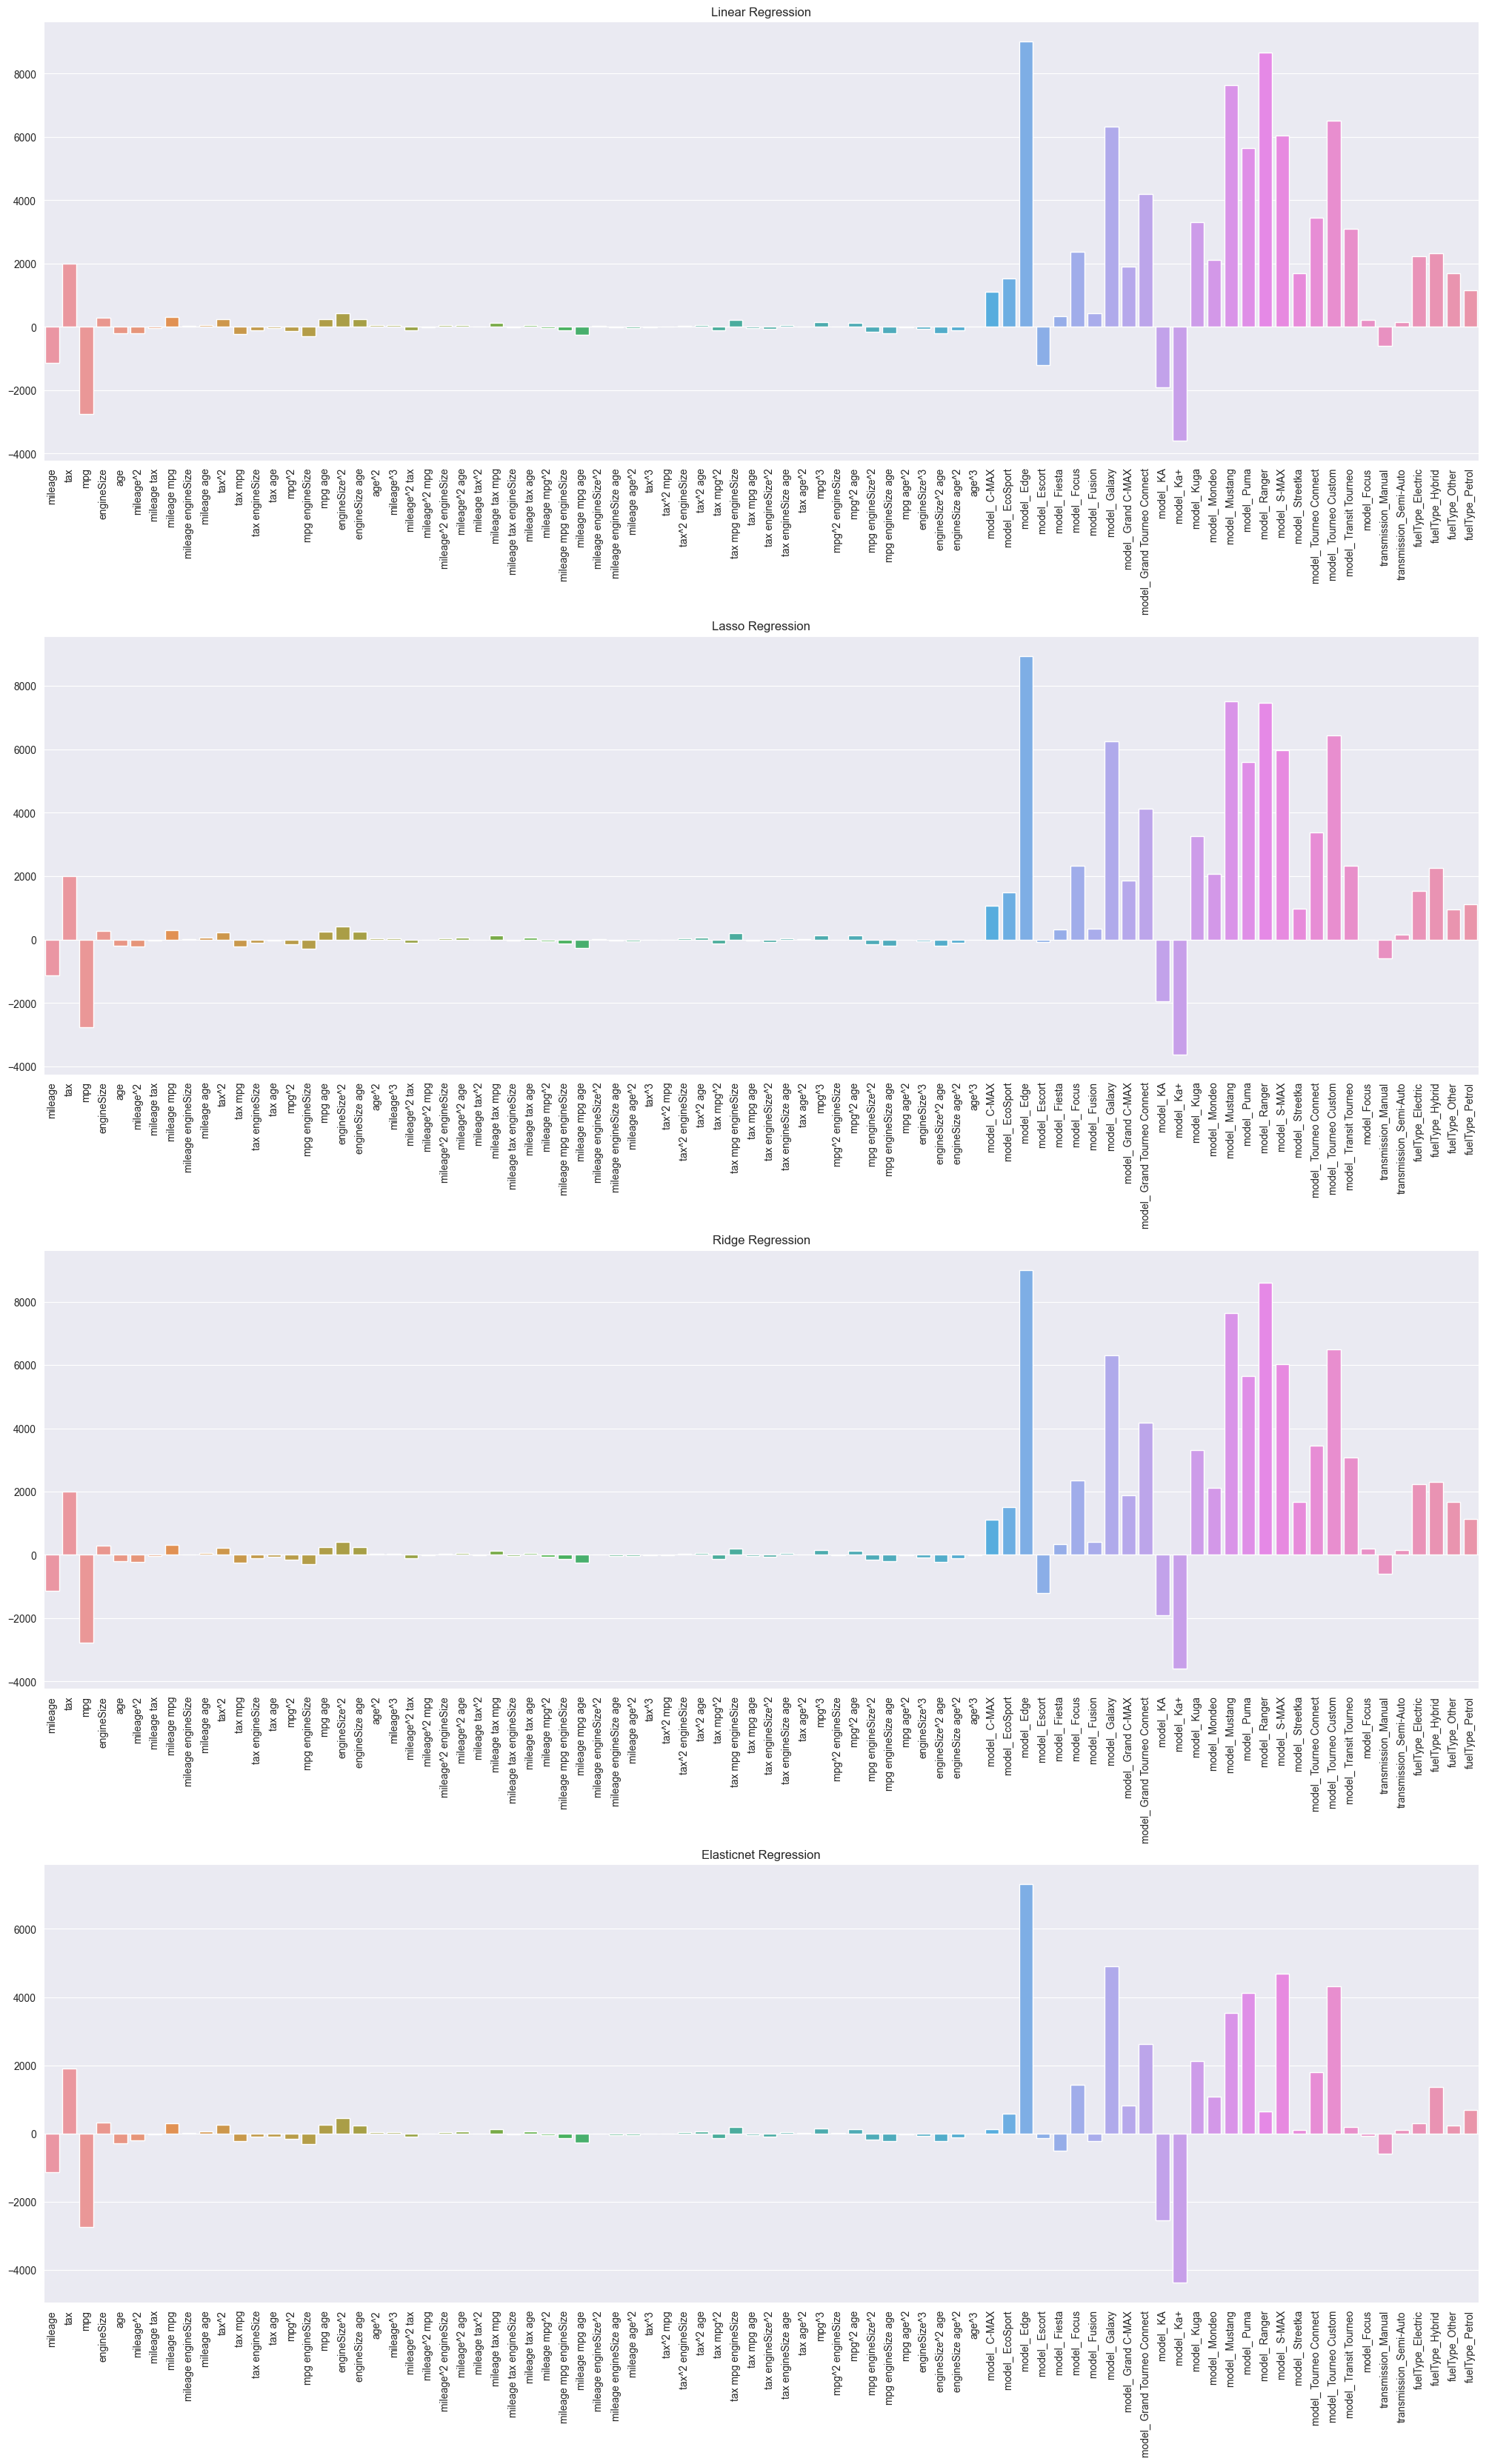

In [419]:
plt.figure(figsize=(25,40))
plt.subplot(411)
sns.barplot(x=feature_importance(linear)[0], y=feature_importance(linear)[1])
plt.xticks(rotation=90)
plt.title("Linear Regression")
plt.subplot(412)
sns.barplot(x=feature_importance(lasso)[0], y=feature_importance(lasso)[1])
plt.xticks(rotation=90)
plt.title("Lasso Regression")

plt.subplot(413)
sns.barplot(x=feature_importance(ridge)[0], y=feature_importance(ridge)[1])
plt.xticks(rotation=90)
plt.title("Ridge Regression")

plt.subplot(414)
sns.barplot(x=feature_importance(elasticNet)[0], y=feature_importance(elasticNet)[1])
plt.xticks(rotation=90)
plt.title("Elasticnet Regression")
plt.subplots_adjust(hspace=0.4)
plt.show()

They all are very similar. The main drivers of these models are features that indicate whether or not the car model is Edge, Mustang, Tourneo Custom, Galaxy, S-MAX, Puma, or Grand Tourneo Connect. These are all derived from the categorical feature - model. Among numerical features, age and mileage have the strongest predictive power. Most interaction terms and polynomial features have low estimates in comparison to others.

## 6. Conclusion
This analysis shows that feature engineering can have a large effect on the model performance, and if the data are sufficiently large, cross-validation should be preferred over train-test-split to construct model evaluation. In my case, even though the predictors have high multicollinearity, their coefficients were not shrunk by the Lasso model, and it is shown that regularization does not always make big improvement on a given model. In the end, the Lasso regression has the highest $R^2$ when predicting on the test set, and categories of car model appear to be the most important features to predict a car price. Also, Lasso did shrink some of the coefficients that are not so important in terms of prediction.